In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def buggy_pca(X: np.array, d: int):
    # X: n x D
    # A: D x d
    # Xd: n x D
    A = np.zeros((X.shape[1], d))
    U, S, Vh = np.linalg.svd(X)
    A = np.array(Vh[:d]).T
    Xt = X @ A
    # reconstruct
    Xr = Xt @ A.T
    return Xt, (U, S, Vh, A), Xr

In [3]:
def demeaned_pca(X: np.array, d: int):
    # X: n x D
    # A: D x d
    # Xd: n x D
    mean = np.mean(X, axis=0)
    Xm = X - mean
    A = np.zeros((X.shape[1], d))
    U, S, Vh = np.linalg.svd(Xm)
    A = np.array(Vh[:d]).T
    Xt = Xm @ A
    # reconstruct
    Xr = (Xt @ A.T) + mean
    return Xt, (U, S, Vh, A), Xr

In [4]:
def normalized_pca(X: np.array, d: int):
    # X: n x D
    # A: D x d
    # Xd: n x D
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    Xn = (X - mean) / std
    A = np.zeros((X.shape[1], d))
    U, S, Vh = np.linalg.svd(Xn)
    A = np.array(Vh[:d]).T
    Xt = Xn @ A
    # reconstruct
    Xr = (Xt @ A.T) * std + mean
    return Xt, (U, S, Vh, A), Xr

In [5]:
def dro(X: np.array, d: int):
    b = np.mean(X, axis=0)
    Xm = X - b
    U, S, Vh = np.linalg.svd(Xm)
    Ud = U[:,:d] # n x d
    Sd = np.zeros((d, d)) # d x d
    for i in range(d):
        Sd[i, i] = S[i]
    Z = Ud @ Sd  # n x d
    A = Vh[:d].T # D x d
    # scale Z to have 0 mean and identity covariance
    mean = np.mean(Z, axis=0)
    Zm = Z - mean
    Zcov = np.cov(Zm, rowvar=False)
    inv_sqrt_cov = None
    if d > 1:
        evals, evecs = np.linalg.eigh(Zcov)
        Zdiag = np.diag(1.0 / np.sqrt(evals))
        inv_sqrt_cov = (evecs @ Zdiag) @ evecs.T
        Zs = Zm @ inv_sqrt_cov
        # reconstruct
        Xr = (Zs @ np.linalg.inv(inv_sqrt_cov) + mean) @ A.T + b
    else:
        inv_sqrt_cov = 1 / np.sqrt(Zcov)
        Zs = Zm * inv_sqrt_cov
        # reconstruct
        Xr = (Zs / inv_sqrt_cov + mean) @ A.T + b
    return Zs, (U, S, Vh, A, Z, b), Xr

In [6]:
def calc_err(X: np.array, R: np.array) -> float:
    error = np.sum((X - R)**2)
    return error

### 2 Dimensions

In [7]:
data2d = np.loadtxt('./data/data2D.csv', delimiter=',', dtype=float)

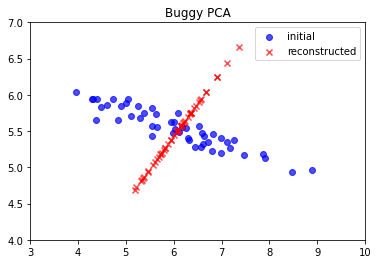

In [8]:
buggy_d, _, buggy_r = buggy_pca(data2d, 1)
plt.scatter(data2d[:,0], data2d[:,1], c='b', marker='o', alpha=.7, label='initial')
plt.scatter(buggy_r[:,0], buggy_r[:,1], c='r', marker='x', alpha=.7, label='reconstructed')
plt.title('Buggy PCA')
plt.xlim(3, 10)
plt.ylim(4, 7)
plt.legend()
plt.show()

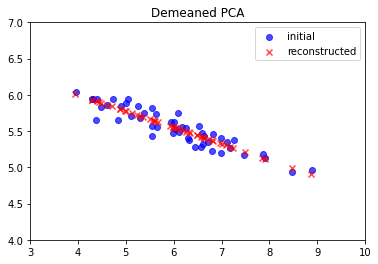

In [9]:
demean_d, _, demean_r = demeaned_pca(data2d, 1)
plt.scatter(data2d[:,0], data2d[:,1], c='b', marker='o', alpha=.7, label='initial')
plt.scatter(demean_r[:,0], demean_r[:,1], c='r', marker='x', alpha=.7, label='reconstructed')
plt.title('Demeaned PCA')
plt.xlim(3, 10)
plt.ylim(4, 7)
plt.legend()
plt.show()

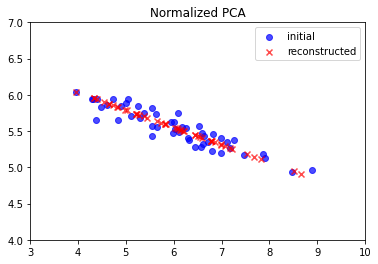

In [10]:
norm_d, _, norm_r = normalized_pca(data2d, 1)
plt.scatter(data2d[:,0], data2d[:,1], c='b', marker='o', alpha=.7, label='initial')
plt.scatter(norm_r[:,0], norm_r[:,1], c='r', marker='x', alpha=.7, label='reconstructed')
plt.title('Normalized PCA')
plt.xlim(3, 10)
plt.ylim(4, 7)
plt.legend()
plt.show()

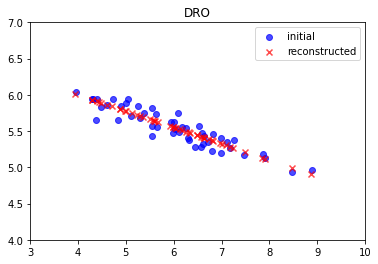

In [11]:
dro_d, _, dro_r = dro(data2d, 1)
plt.scatter(data2d[:,0], data2d[:,1], c='b', marker='o', alpha=.7, label='initial')
plt.scatter(dro_r[:,0], dro_r[:,1], c='r', marker='x', alpha=.7, label='reconstructed')
plt.title('DRO')
plt.xlim(3, 10)
plt.ylim(4, 7)
plt.legend()
plt.show()

In [12]:
print('Reconstruction Errors: ')
print('Buggy PCA: ' + str(calc_err(data2d, buggy_r)))
print('Demeaned PCA: ' + str(calc_err(data2d, demean_r)))
print('Normalized PCA: ' + str(calc_err(data2d, norm_r)))
print('DRO: ' + str(calc_err(data2d, dro_r)))

Reconstruction Errors: 
Buggy PCA: 44.34515418673971
Demeaned PCA: 0.500304281425646
Normalized PCA: 2.473604172738534
DRO: 0.500304281425646


### 1000 Dimensions

In [13]:
data = np.loadtxt('./data/data1000D.csv', delimiter=',', dtype=float)
data.shape

(500, 1000)

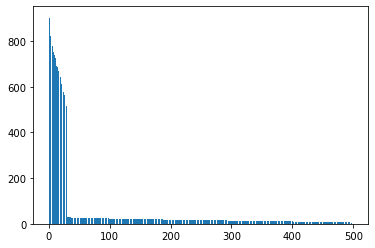

In [14]:
mean = np.mean(data, axis=0)
Xm = data - mean
U, S, Vh = np.linalg.svd(Xm)
plt.bar(range(len(S)), S)
plt.show()

We can see a "knee point". Let's look at a subset:

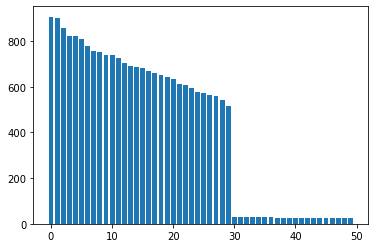

In [15]:
plt.bar(range(50), S[:50])
plt.show()

In [16]:
print(S[28])
print(S[29])
print(S[30])

541.1008412778775
514.786013128445
28.72590083294839


It looks like the first 30 singular values are the most significant values, and everything after has a significant dropoff. So we'll choose d = 30.

In [17]:
buggy_d, buggy_p, buggy_r = buggy_pca(data, 30)
demean_d, demean_p, demean_r = demeaned_pca(data, 30)
norm_d, norm_p, norm_r = normalized_pca(data, 30)
dro_d, dro_p, dro_r = dro(data, 30)
print('Reconstruction Errors: ')
print('Buggy PCA: ' + str(calc_err(data, buggy_r)))
print('Demeaned PCA: ' + str(calc_err(data, demean_r)))
print('Normalized PCA: ' + str(calc_err(data, norm_r)))
print('DRO: ' + str(calc_err(data, dro_r)))

Reconstruction Errors: 
Buggy PCA: 401365.6993101792
Demeaned PCA: 136522.9794893014
Normalized PCA: 136814.2904988116
DRO: 136522.9794893014
